In [5]:
import csv
import numpy as np
# import tensorflow as tf
# import string
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
import pandas as pd
from numpy.lib.function_base import append
from numpy import array
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('Spotify_tracks.csv')
data.columns = ["order",'playlist_id',"track_id",'danceability',"energy","speechiness","acousticness","instrumentalness","liveness","valence","tempo"]
data.head()
data.info

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0) # 80% training and 20% test

<bound method DataFrame.info of       order             playlist_id                track_id  danceability  \
0         0  37i9dQZF1DXcBWIGoYBM5M  2FeBslNBMdR9V58uv6hd2t         0.790   
1         1  37i9dQZF1DXcBWIGoYBM5M  1PckUlxKqWQs3RlWXVBLw3         0.836   
2         2  37i9dQZF1DXcBWIGoYBM5M  4LRPiXqCikLlN15c3yImP7         0.520   
3         3  37i9dQZF1DXcBWIGoYBM5M  1rDQ4oMwGJI7B4tovsBOxc         0.905   
4         4  37i9dQZF1DXcBWIGoYBM5M  0QBzMgT7NIeoCYy3sJCof1         0.756   
...     ...                     ...                     ...           ...   
8019     95  37i9dQZF1DX8a1tdzq5tbM  35cYPqBXqob7yitjk4Cx3M         0.418   
8020     96  37i9dQZF1DX8a1tdzq5tbM  04hY9ZE6jatvZjsu1Q9nPc         0.792   
8021     97  37i9dQZF1DX8a1tdzq5tbM  2AnEHhSLWVJJMSQECOcyyx         0.620   
8022     98  37i9dQZF1DX8a1tdzq5tbM  2OZrV4yyOZNuEFx22VVfFm         0.664   
8023     99  37i9dQZF1DX8a1tdzq5tbM  6fehhZGfpzXQLoRCUjE463         0.482   

      energy  speechiness  acousticness  in

In [3]:
spotifyCols = list(data)[3:10]
sp_df = data[spotifyCols].astype(float)
sp_df.insert(0 , "playlist_id", data["playlist_id"])

In [6]:
playlist_df = []
temp_playlist = []
prev_playlist = sp_df.loc[1,"playlist_id"]
for index, row in sp_df.iterrows():
  if(row["playlist_id"] == prev_playlist):
    temp_playlist.append(list(row))
  else:
    playlist_df.append(temp_playlist)
    prev_playlist = row["playlist_id"]
    temp_playlist = []

for playlist in playlist_df:
  for track in playlist:
    del track[0]
print(playlist_df)
spotify_trainX = []
spotify_trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

for playlist in playlist_df:
  for i in range(n_past, len(playlist) - n_future +1):
      spotify_trainX.append(playlist[i - n_past:i])
      spotify_trainY.append(playlist[i + n_future - 1:i + n_future])

spotify_trainX, spotify_trainY = np.array(spotify_trainX), np.array(spotify_trainY)
print('trainX shape == {}.'.format(spotify_trainX.shape))
print('trainY shape == {}.'.format(spotify_trainY.shape))

# print(spotify_trainX[:5])

[[[0.79, 0.67, 0.105, 0.377, 2.32e-06, 0.119, 0.408], [0.836, 0.743, 0.0656, 0.0995, 0.0, 0.335, 0.722], [0.52, 0.731, 0.0557, 0.342, 0.00101, 0.311, 0.662], [0.905, 0.563, 0.102, 0.0254, 9.71e-06, 0.113, 0.324], [0.756, 0.697, 0.0401, 0.182, 0.0, 0.333, 0.956], [0.804, 0.674, 0.0333, 0.294, 1.18e-06, 0.115, 0.292], [0.604, 0.741, 0.0475, 0.178, 3.49e-05, 0.409, 0.473], [0.669, 0.773, 0.153, 0.038, 0.0, 0.113, 0.377], [0.737, 0.846, 0.22, 0.00614, 0.0, 0.0486, 0.546], [0.41, 0.611, 0.0467, 0.0228, 0.0, 0.116, 0.0899], [0.824, 0.764, 0.0854, 0.0888, 0.00294, 0.117, 0.881], [0.775, 0.736, 0.247, 0.319, 0.00116, 0.127, 0.362], [0.761, 0.525, 0.0944, 0.44, 6.7e-06, 0.0921, 0.531], [0.671, 0.636, 0.103, 0.515, 0.000411, 0.172, 0.262], [0.463, 0.642, 0.34, 0.314, 0.0, 0.0686, 0.339], [0.376, 0.657, 0.0768, 0.0858, 0.0, 0.0884, 0.203], [0.69, 0.626, 0.306, 0.105, 0.000335, 0.0881, 0.912], [0.87, 0.516, 0.0541, 0.656, 0.00823, 0.11, 0.53], [0.788, 0.859, 0.0856, 0.281, 0.0, 0.0424, 0.822], [0.

In [7]:
spotify_model = Sequential()
spotify_model.add(LSTM(64, activation='relu', input_shape=(spotify_trainX.shape[1], spotify_trainX.shape[2]), return_sequences=True))
spotify_model.add(Dropout(0.2))
spotify_model.add(LSTM(32, activation='relu', return_sequences=False))
spotify_model.add(Dropout(0.2))
spotify_model.add(Dense(spotify_trainY.shape[2]))

spotify_model.compile(optimizer='adam', loss='mse')
spotify_model.summary()


# fit the model
spotify_history = spotify_model.fit(spotify_trainX, spotify_trainY, epochs=20, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             18432     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 7)                 231       
                                                                 
Total params: 31,079
Trainable params: 31,079
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
412/412 [==============================] 

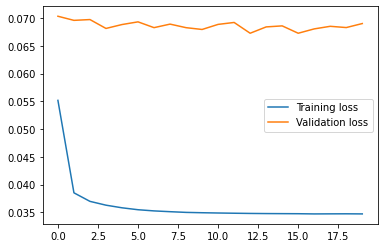

In [8]:
plt.plot(spotify_history.history['loss'], label='Training loss')
plt.plot(spotify_history.history['val_loss'], label='Validation loss')
plt.legend()

In [9]:
#prediction data
predData = pd.read_csv('noahmasur_tracks.csv')

test_songs = predData.iloc[:5,3:10]
test_songs = np.expand_dims(test_songs,axis=0)

prediction = spotify_model.predict(test_songs) #shape = (n, 1) where n is the n_days_for_prediction
# print(test_songs.round(3))
print(prediction.round(4))

[[0.5924 0.6823 0.0875 0.1974 0.0463 0.1859 0.5211]]
